In [89]:
from load_dataset import *
from layers import *

In [98]:
cty_size

75

In [2]:
n_embd = 32
n_embd_city = 5
n_layer = 2
tkemb = Embedding(vocab_size, n_embd)
ctemb = Embedding(cty_size, n_embd_city)
batch_size = 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,))

In [3]:
Ytr[ix].shape

torch.Size([32])

In [84]:
Dict_cty = {c:sum([cty==c for cty in countries]) for c in list(set(countries))}

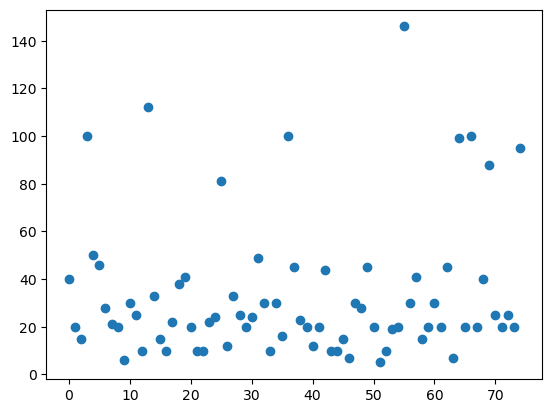

In [86]:
plt.scatter(range(cty_size), Dict_cty.values())

In [4]:
AAA = Sequential([Block(n_embd*block_size+n_embd_city) for _ in range(n_layer)])

NameError: name 'Block' is not defined

In [28]:
[i.shape for i in AAA.parameters()]

[torch.Size([101, 101]),
 torch.Size([101]),
 torch.Size([101]),
 torch.Size([101, 101]),
 torch.Size([101]),
 torch.Size([101])]

In [65]:
n_embd = 32
n_embd_city = 5
n_layer = 2

class Block(nn.Module):

    def __init__(self, fan_in):
        super().__init__()
        self.li = Linear(fan_in, fan_in, bias=False)
        self.bn = BatchNorm1d(fan_in)  # batchnorm

    def forward(self, x):
        x = x + F.tanh(self.bn(self.li(x))) # residue net
        return x
    
    def parameters(self):
        return self.li.parameters()+self.bn.parameters()

class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = Embedding(vocab_size, n_embd)
        self.country_embedding_table = Embedding(cty_size, n_embd_city)        
        self.blocks = Sequential([Block(n_embd*block_size+n_embd_city) for _ in range(n_layer)])
        self.linear_f = Linear(n_embd*block_size+n_embd_city, vocab_size)

    def forward(self, idx, idx_cty, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C1)
        cty_emb = self.country_embedding_table(idx_cty) # (B,C2)
        x = torch.cat((tok_emb.view(B,-1), cty_emb),1) # (B,T*C1+C2)
        x = self.blocks(x) # (B,T*C1+C2)
        logits = self.linear_f(x) # (B,vocab_size)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def parameters(self):
        return self.token_embedding_table.parameters()+ \
                self.country_embedding_table.parameters() + \
                self.blocks.parameters()+self.linear_f.parameters()

    def generate(self, idx, idx_cty, max_new_tokens=20):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond, idx_cty)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            if idx_next == 0:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [66]:
model = Model()

In [67]:
[i.shape for i in model.parameters()]

[torch.Size([143, 32]),
 torch.Size([75, 5]),
 torch.Size([101, 101]),
 torch.Size([101]),
 torch.Size([101]),
 torch.Size([101, 101]),
 torch.Size([101]),
 torch.Size([101]),
 torch.Size([101, 143]),
 torch.Size([143])]

In [68]:
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


40343


Model(
  (token_embedding_table): Embedding()
  (country_embedding_table): Embedding()
  (blocks): Sequential()
  (linear_f): Linear()
)

In [69]:
vocab_size
# logits, loss = model(Xb, Cb, Yb)

143

In [70]:
# same optimization as last time
max_steps = 20000
eval_step = 100
batch_size = 32
lossi = []
lossT = []
lossD = []
learning_rate = 0.01

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for i in range(max_steps):
    if i%eval_step == 0:
        for block in model.blocks.layers:
            block.bn.training = False
        lossTr, lossDe = eval_loss()
        print(f'{i:7d}/{max_steps:7d}: {lossTr:.4f} {lossDe:.4f}')
        lossT.append(lossTr)
        lossD.append(lossDe)
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Cb, Yb = Xtr[ix], Ctr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    logits, loss = model(Xb, Cb, Yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  20000: 5.8502 5.8117
      0/  20000: 6.1977
    100/  20000: 2.7794 2.9366
    200/  20000: 2.5692 2.7062
    300/  20000: 2.4168 2.5926
    400/  20000: 2.3591 2.5025
    500/  20000: 2.3172 2.4807
    600/  20000: 2.2047 2.4119
    700/  20000: 2.1852 2.3851
    800/  20000: 2.1268 2.3759
    900/  20000: 2.1275 2.3871
   1000/  20000: 2.0864 2.3851
   1100/  20000: 2.0683 2.3723
   1200/  20000: 2.0173 2.3330
   1300/  20000: 1.9820 2.2902
   1400/  20000: 1.9373 2.3106
   1500/  20000: 1.9268 2.2387
   1600/  20000: 1.9213 2.2862
   1700/  20000: 1.8838 2.2562
   1800/  20000: 1.8688 2.2571
   1900/  20000: 1.8587 2.2833
   2000/  20000: 1.8685 2.2916
   2100/  20000: 1.8229 2.2537
   2200/  20000: 1.8097 2.2406
   2300/  20000: 1.8145 2.2386
   2400/  20000: 1.8318 2.3124
   2500/  20000: 1.7550 2.2401
   2600/  20000: 1.7995 2.3139
   2700/  20000: 1.7689 2.2982
   2800/  20000: 1.7455 2.2747
   2900/  20000: 1.7487 2.2951
   3000/  20000: 1.7164 2.2428
   3100/  20000

In [63]:
# put layers into eval mode (needed for batchnorm especially)
for block in model.blocks.layers:
    block.bn.training = False

# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,c,y = {
        'train': (Xtr, Ctr, Ytr),
        'val': (Xde, Cde, Yde),
    }[split]
    logits, loss = model(x, c, y)
    print(split, loss.item())
    
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def eval_loss():
    _, lossTr = model(Xtr, Ctr, Ytr)
    _, lossDe = model(Xde, Cde, Yde)
    return lossTr.item(), lossDe.item()
    
split_loss('train')
split_loss('val')

train 1.3916823863983154
val 2.1538608074188232


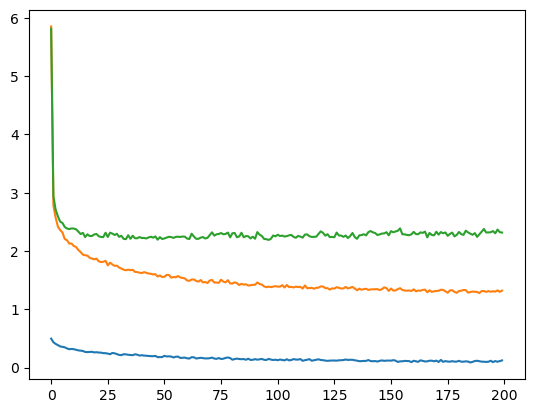

In [72]:
plt.plot(torch.tensor(lossi).view(-1,100).mean(1))
plt.plot(torch.tensor(lossT))
plt.plot(torch.tensor(lossD))